
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/abhinandanarya06/OCR/blob/master/Preparing_Model_for_OCR.ipynb#scrollTo=4f5Gj3j5U9mN)


# **OCR Model Training**




###**Installing and Importing Required Libraries**


---



1. OpenCV - Image Processing Library
2. Tensorflow 2.0 - Machine learning Library

In [0]:
!pip install tensorflow==2.0rc1

from IPython.display import clear_output
import cv2 
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

clear_output()

###**Unzipping My DATASET**


---


This will create a data directory. The hierarchy of this directory as shown below:

          data --+-> letters --+--> a
                 +-> noise     +--> b
                 +-> number    ......

In [0]:
!unzip data.zip
clear_output()

###**Function to show image**


---


"imshow(image)" where image is np.array type representing image to show.

In [0]:
def imshow(image):
  plt.imshow(image, cmap = 'gray', interpolation = 'bicubic')
  plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
  plt.show()

###**Mapping Letters classes to numbers**
Keywords contains letters with appropriate index number mapping

In [0]:
keywords = [chr(c) for c in range(ord('a'), ord('z')+1)]
cap = ['A', 'B', 'D', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'Q', 'R', 'T']
keywords = keywords + cap
keywords = keywords + ['noise']

In [0]:
print(len(keywords))

41


###**Preparing Data for Training**

---



In [0]:
data_images = list()
labels = list()
i = 0
for c in keywords:
  path = 'data/letters/'+c+'/'
  files = os.listdir(path)
  for name in files:
      img = cv2.imread(path+name)
      try:
        img = cv2.resize(img, (50, 50), interpolation = cv2.INTER_AREA)
      except:
        continue
      data_images.append(img)
  labels = labels + [i]*len(files)
  i += 1


In [0]:
data_images = np.array(data_images)
labels = np.array(labels)

In [0]:
print(labels.shape, images.shape)

(23462,) (23462, 50, 50, 3)


###**Model Architecture**


---


Layer Sequence (Sequencial Model) : 


1.   Conv2D Layer
2.   Flatten Operation
3.   Dense Layer with 200 units
4.   Dense Layer with 41 units




In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape = (50, 50, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(200, activation = 'relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(41)
])

In [0]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
flatten_7 (Flatten)          (None, 73728)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 200)               14745800  
_________________________________________________________________
dropout_7 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 41)                8241      
Total params: 14,754,937
Trainable params: 14,754,937
Non-trainable params: 0
_________________________________________________________________


**Training starts with callback of early stopping with patience 2**

---



In [0]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [0]:
model.fit(images, labels, epochs=20, callbacks = [callback])
clear_output()

In [0]:
test_loss, test_acc = model.evaluate(images,  labels, verbose=2)

print('\nTest accuracy:', test_acc)

23462/1 - 29s - loss: 0.2747 - accuracy: 0.9715

Test accuracy: 0.9715284




---


---





# **OCR Model Testing**


 

####**Adding Softmax Activation**

---



In [0]:
probablity = tf.keras.Sequential(
    model,
    tf.keras.layers.Softmax()
)

###**Creating Directory 'gen'**


---

'gen' directory is created with its sub directory for storing by machine identified data

In [0]:
!mkdir gen
for c in keywords:
  os.system('mkdir gen/'+c)

###**Saving the trained model**


---

'model' model is saved in current directory with name 'model.hd5'


In [0]:
model.save('model.h5')
clear_output()

In [0]:
model = tf.keras.models.load_model('model.h5')

### **OCR Deployment Demo (Testing Model)**


---



#####***'sort_chars(line)'*** Function to sort characters in given line

In [0]:
def sort_chars(line):
  res = list()
  while len(line) > 0:
    mx = 100000
    m = 0
    for c in line:
      if c[1][0] <= mx:
        mx = c[1][0]
        m = c
    line.remove(m)
    res.append(m)
  return res

#####"***sort_lines_by_yval(lines)***" function sorts list of lines according to its y coordinate in image space

In [0]:
def sort_lines_by_yval(lines):
  res = list()
  while len(lines) > 0:
    mn = 100000
    m = 0
    for line in lines:
      if line[0][1][1] < mn:
        mn = line[0][1][1]
        m = line
    lines.remove(m)
    res.append(m)
  return res

#####***arrangeline(characters)*** Function to group characters in given image by lines

In [0]:
def group_chars_by_line(characters):
  lines = list()
  linei = 0
  while len(characters) > 0:
      m = characters[0]
      my = m[1][1]
      my_plus_h = m[1][1]+m[2][1]
      lines.append([m])
      for c in characters[1:]:
          if my <= c[1][1]+c[2][1]/2 and c[1][1]+c[2][1]/2 <= my_plus_h:
              if my > c[1][1]:
                my = c[1][1]
              if my_plus_h < c[1][1]+c[2][1]:
                my_plus_h = c[1][1]+c[2][1]
              lines[linei].append(c)
              characters.remove(c)
      lines[linei]= sort_chars(lines[linei])
      linei += 1
      characters.remove(m)
  return lines

#####**Main Run Start Point**

****************************** Text in image 5.jpg ****************************** 



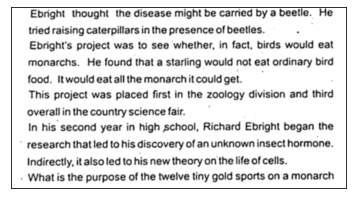

Ednght thought the d sease m lghtbe carned by a beetle e 
tnEd ra s ng E terplllars ln lhe presennce ofbeetle
E dnghts project w as to see w hethen n fact blrds w ould ean
m onarchs E e found thata starllng w ould noteatordlnaE blr
foob lt culd eatallthe m onarch ltcould ge
m h s groject w as glaced nlrst ln the zoology elvlslon ane thlr
o eranll n the countE sclence fal
ln hls seco nd year ln hlgh g chool R lchard E brnght degan th
reseanrch thatlend to h s e lscove ofan unknow n lnsecthorm on
tnd rectly lta so led to hls new theo o n the llfe ofcell
w hantls the g urgo se ofthe tw elve tlny gold sgo s o n a m onarc
-------------------------------------------------------------------------------- 


****************************** Text in image 6.jpg ****************************** 



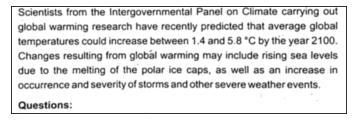

scle ntIs ts fro m th e lnte rg o ve rn m e nta l p a ne l o n c llm ate ca r lng o u
g lo balw arm lng research have recently predlcted that average g lo ba
teEm pe ratures co u ld lncrease betw ee n a and G s ec by the yea rE no
G ha nges resultlng from globalw arm lng m ay lnclude rlslng sea leve l
bue to the m eltlng of the polar lce caps as w ell as an lncrease l
occurrence and severlty ofstorm s and otherseve re w eathe revent
Q uesEIo n 
-------------------------------------------------------------------------------- 


****************************** Text in image 3.jpg ****************************** 



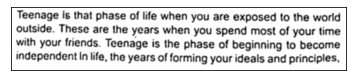

De enage s thatphase oflfe w hen you are exgosed tc the w orl
outside These are the yeanrs w hen you spend m ostofycur tm 
hth you rends TeenageE ls the phase of beglnnlng to beccm 
nuegendenttn ltfe the years ofform lng yourldeals and prnclple
-------------------------------------------------------------------------------- 


****************************** Text in image 1.jpg ****************************** 



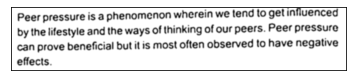

peerpressu re ls a pheno m enon w hereln w e tenR to getlnnuence
dy the llfestyle and the w ays oethlnk ng ofo urpeers p ee rpressur
E n pro e benenclatbutltls m ostoften obsew ed to have neg attv
effect
-------------------------------------------------------------------------------- 




In [0]:
imgs = [f for f in os.listdir('.') if f.endswith('.jpg')]
#i = 0
img_no = 0
for img in imgs:
    character_list = list()
    img = cv2.imread(img)
    color = img
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.medianBlur(img,5)
    img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,21,10)
    contours, hierarchy = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    for c in contours:
      try:
        x,y,w,h = cv2.boundingRect(c)
        try:
            show = color[y-2:y+h+2, x-2:x+w+2]
        except:
            show = color[y:y+h, x:x+w]
        test_data = cv2.resize(show,(50,50),interpolation = cv2.INTER_AREA)
        test_data=np.array([test_data])
        cmd = np.argmax(probablity.predict(test_data))
        if cmd < 40:
          character_list.append([keywords[cmd], (x,y), (w,h)])
        #cv2.imwrite('gen/'+keywords[cmd]+'/'+str(i)+'.jpg', show)
        #i+=1
      except:
            continue
    text = group_chars_by_line(character_list)#, img)
    text = sort_lines_by_yval(text)
    print('*'*30, 'Text in image', imgs[img_no], '*'*30,'\n')
    imshow(img)
    addw = dno = 0
    for l in text:
      wno = 1
      for w in l[:-1]:
          fut = l[wno]
          wid = fut[1][0]-w[1][0]
          addw += wid
          dno += 1
          avg_width = addw/dno
          print(w[0], end='')
          if wid >= avg_width*1.08:
            print(end=' ')
          wno += 1
      print()
    print('-'*80, '\n\n')
    img_no += 1

###**Packing Generated Data for further checking by human**

---



In [0]:
!tar cf gen.tar gen
clear_output()

###**Watching the model test results**


---



In [0]:
for c in keywords:
  path='gen/{}/'.format(c)
  files = os.listdir(path)
  for img in files[:2]:
    img=cv2.imread(path+img,0)
    imshow(img)
    print(' '*10, c)